In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame, to_datetime
from sklearn.svm import SVR
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.api import ExponentialSmoothing
from keras.models import Sequential
import pickle
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_csv('/content/output (1).csv')
df


,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,AEP,20.083557,34.939999,36.000000,34.799999,35.099998,4076600.0
1,2010-01-05,AEP,19.853634,34.540001,35.119999,34.360001,34.980000,5112400.0
2,2010-01-06,AEP,20.054811,34.889999,35.099998,34.459999,34.560001,3157400.0
3,2010-01-07,AEP,20.227253,35.189999,35.310001,34.689999,34.779999,3581200.0
4,2010-01-08,AEP,20.468672,35.610001,35.810001,34.930000,35.180000,3980600.0
...,...,...,...,...,...,...,...,...
3605,2024-05-01,AEP,88.150002,88.150002,89.360001,85.699997,85.760002,5344700.0
3606,2024-05-02,AEP,88.250000,88.250000,88.639999,87.400002,88.050003,2672800.0
3607,2024-05-03,AEP,88.599998,88.599998,89.279999,87.949997,89.000000,3332400.0
3608,2024-05-06,AEP,88.809998,88.809998,89.190002,88.199997,88.760002,2354100.0


In [ ]:
df.isnull().sum()


Date         0
Symbol       0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [ ]:
df.dtypes

Date          object
Symbol        object
Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume       float64
dtype: object

In [ ]:
### using interpolation as the data follows a certain trend

df.interpolate(method='linear', inplace=True)

In [ ]:
### normalizing the data as certain neural networks are sensitive to scale of the features

numeric_columns = df.select_dtypes(include=['float64']).columns
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df[numeric_columns])
normalized_df = pd.DataFrame(normalized_data, columns=numeric_columns)
non_numeric_columns = df.select_dtypes(exclude=['float64']).columns
normalized_df[non_numeric_columns] = df[non_numeric_columns]


In [ ]:
normalized_df

,Adj Close,Close,High,Low,Open,Volume,Date,Symbol
0,0.022700,0.053497,0.067399,0.085962,0.060736,0.165178,2010-01-04,AEP
1,0.019852,0.048107,0.055608,0.080179,0.059124,0.212227,2010-01-05,AEP
2,0.022344,0.052823,0.055340,0.081493,0.053480,0.123426,2010-01-06,AEP
3,0.024479,0.056866,0.058154,0.084516,0.056436,0.142676,2010-01-07,AEP
4,0.027470,0.062525,0.064853,0.087671,0.061811,0.160818,2010-01-08,AEP
...,...,...,...,...,...,...,...,...
3605,0.865800,0.770516,0.782393,0.754995,0.741467,0.222778,2024-05-01,AEP
3606,0.867038,0.771864,0.772746,0.777340,0.772239,0.101414,2024-05-02,AEP
3607,0.871373,0.776580,0.781321,0.784569,0.785004,0.131375,2024-05-03,AEP
3608,0.873975,0.779410,0.780115,0.787855,0.781779,0.086938,2024-05-06,AEP


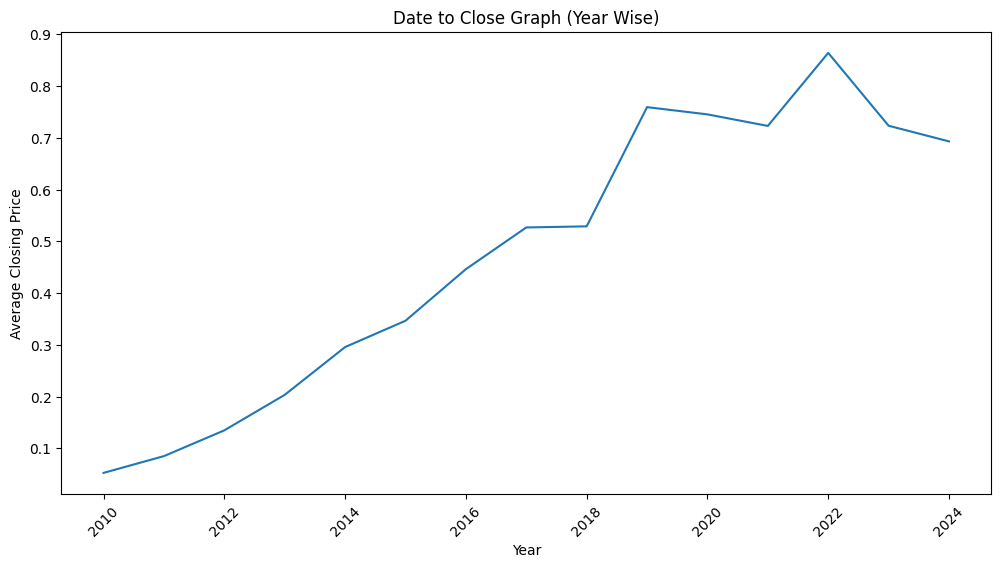

In [ ]:
# Extract year from the date column
normalized_df['Year'] = pd.to_datetime(normalized_df['Date']).dt.year

# Group data by year and calculate closing price mean
grouped_df = normalized_df.groupby('Year')['Close'].mean()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(grouped_df.index, grouped_df.values)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Average Closing Price')
plt.title('Date to Close Graph (Year Wise)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:
normalized_df.tail(365)

,Adj Close,Close,High,Low,Open,Volume,Date,Symbol
3245,0.876550,0.845439,0.853946,0.851472,0.846950,0.129304,2022-11-22,AEP
3246,0.893258,0.864573,0.860780,0.856598,0.848293,0.130948,2022-11-23,AEP
3247,0.897259,0.869155,0.868819,0.876577,0.870331,0.036878,2022-11-25,AEP
3248,0.894317,0.865786,0.888517,0.863959,0.894652,0.185732,2022-11-28,AEP
3249,0.887610,0.858105,0.856358,0.864222,0.860253,0.072876,2022-11-29,AEP
...,...,...,...,...,...,...,...,...
3605,0.865800,0.770516,0.782393,0.754995,0.741467,0.222778,2024-05-01,AEP
3606,0.867038,0.771864,0.772746,0.777340,0.772239,0.101414,2024-05-02,AEP
3607,0.871373,0.776580,0.781321,0.784569,0.785004,0.131375,2024-05-03,AEP
3608,0.873975,0.779410,0.780115,0.787855,0.781779,0.086938,2024-05-06,AEP


# **Prophet Model**

In [ ]:
normalized_df.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)
normalized_df

,y,Close,High,Low,Open,Volume,ds,Symbol
0,0.022700,0.053497,0.067399,0.085962,0.060736,0.165178,2010-01-04,AEP
1,0.019852,0.048107,0.055608,0.080179,0.059124,0.212227,2010-01-05,AEP
2,0.022344,0.052823,0.055340,0.081493,0.053480,0.123426,2010-01-06,AEP
3,0.024479,0.056866,0.058154,0.084516,0.056436,0.142676,2010-01-07,AEP
4,0.027470,0.062525,0.064853,0.087671,0.061811,0.160818,2010-01-08,AEP
...,...,...,...,...,...,...,...,...
3605,0.865800,0.770516,0.782393,0.754995,0.741467,0.222778,2024-05-01,AEP
3606,0.867038,0.771864,0.772746,0.777340,0.772239,0.101414,2024-05-02,AEP
3607,0.871373,0.776580,0.781321,0.784569,0.785004,0.131375,2024-05-03,AEP
3608,0.873975,0.779410,0.780115,0.787855,0.781779,0.086938,2024-05-06,AEP


In [ ]:
model = Prophet()

model.fit(normalized_df)

future_dates = pd.date_range(start='2022-11-22', end='2024-05-07', freq='D')
future_df = pd.DataFrame({'ds': future_dates})
forecast = model.predict(future_df)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb85mwnlx/954icw3s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb85mwnlx/79bmxqw8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69859', 'data', 'file=/tmp/tmpb85mwnlx/954icw3s.json', 'init=/tmp/tmpb85mwnlx/79bmxqw8.json', 'output', 'file=/tmp/tmpb85mwnlx/prophet_modellc3wk_3o/prophet_model-20240511085424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:54:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:54:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds      yhat  yhat_lower  yhat_upper
0 2022-11-22  0.794423    0.737952    0.852310
1 2022-11-23  0.794741    0.740223    0.853792
2 2022-11-24  0.795112    0.735670    0.851604
3 2022-11-25  0.796321    0.739608    0.855138
4 2022-11-26  0.806145    0.747195    0.860280


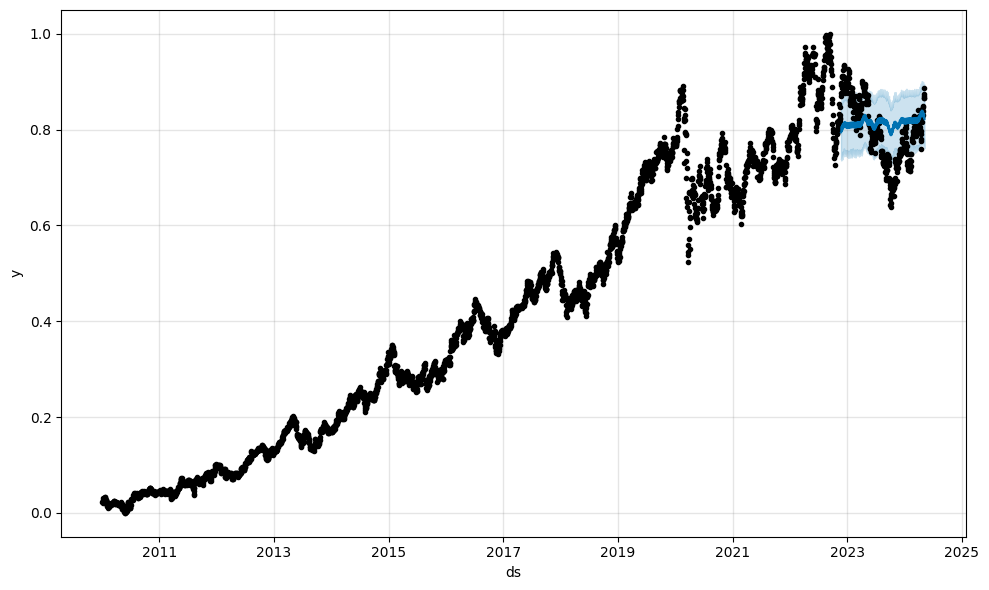

In [ ]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
model.plot(forecast)
plt.show()

MSE:  0.004796246402815629
MAE:  0.057192135444974423
RMSE:  0.06925493775042779


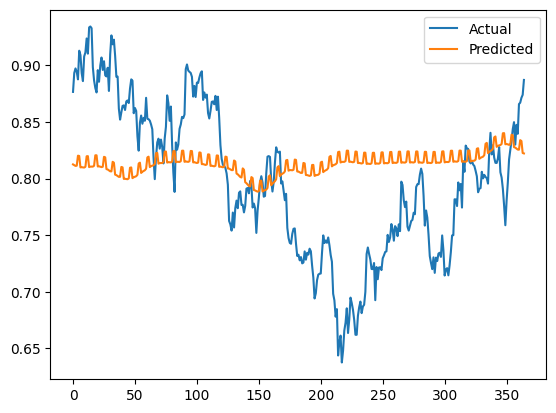

In [ ]:
y_true = normalized_df['y'][-365:].values
y_pred = forecast['yhat'][-365:].values
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print("MSE: " , mse)
print("MAE: ", mae)
print("RMSE: ", rmse)

# Plot expected vs actual values
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()



In [ ]:
import pickle
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# **Support Vector Regression**

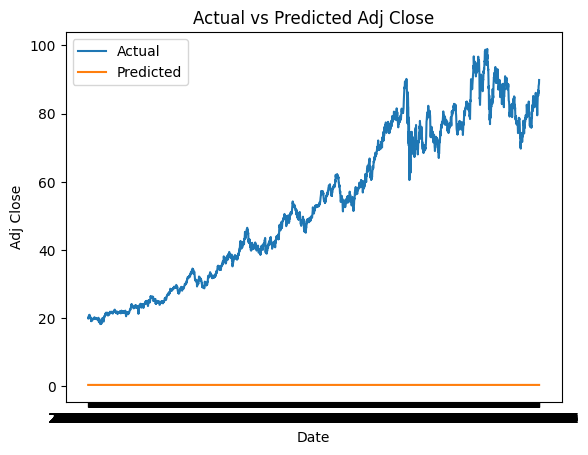

In [ ]:
# Plot expected vs predicted values
plt.plot(df['Date'], df['Adj Close'], label='Actual')
plt.plot(df['Date'], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title('Actual vs Predicted Adj Close')
plt.legend()
plt.show()



In [ ]:

with open('svr_model.pkl', 'wb') as f:
    pickle.dump(svr_model, f)

In [ ]:
normalized_df

,Adj Close,Close,High,Low,Open,Volume,Symbol
Date,,,,,,,
1970-01-01,0.022700,0.053497,0.067399,0.085962,0.060736,0.165178,AEP
1970-01-01,0.019852,0.048107,0.055608,0.080179,0.059124,0.212227,AEP
1970-01-01,0.022344,0.052823,0.055340,0.081493,0.053480,0.123426,AEP
1970-01-01,0.024479,0.056866,0.058154,0.084516,0.056436,0.142676,AEP
1970-01-01,0.027470,0.062525,0.064853,0.087671,0.061811,0.160818,AEP
...,...,...,...,...,...,...,...
1970-01-01,0.865800,0.770516,0.782393,0.754995,0.741467,0.222778,AEP
1970-01-01,0.867038,0.771864,0.772746,0.777340,0.772239,0.101414,AEP
1970-01-01,0.871373,0.776580,0.781321,0.784569,0.785004,0.131375,AEP


# **ETS**

In [ ]:
# normalized_df['Date'] = pd.to_datetime(normalized_df['Date'])

# # # Set 'Date' column as index
# normalized_df.set_index('Date', inplace=True)

# Create and fit ETS model
model = ExponentialSmoothing(normalized_df['Adj Close'], trend='add', seasonal='add', seasonal_periods=12)
fit_model = model.fit()

# Make predictions
predictions = fit_model.forecast(steps=len(normalized_df))

# Calculate evaluation metrics
mse = mean_squared_error(normalized_df['Adj Close'], predictions)
mae = mean_absolute_error(normalized_df['Adj Close'], predictions)
rmse = mse ** 0.5

# Print evaluation metrics
print("MSE:", mse)
print("MAE:", mae)
print("RMSE:", rmse)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MSE: 0.7913444657076013
MAE: 0.886783286198603
RMSE: 0.8895754412682497


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


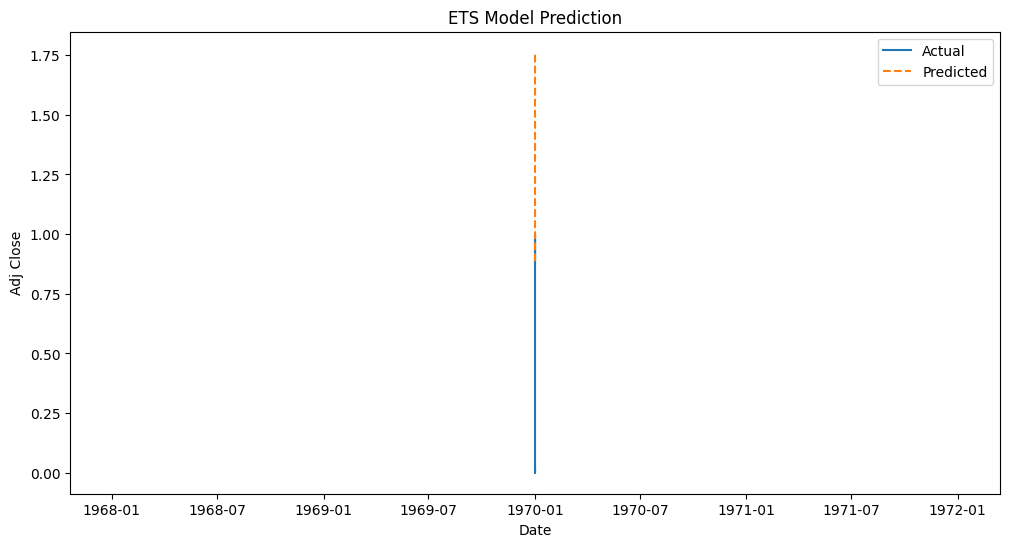

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(normalized_df.index, normalized_df['Adj Close'], label='Actual')
plt.plot(normalized_df.index, predictions, label='Predicted', linestyle='--')
plt.title('ETS Model Prediction')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

In [ ]:
# Print evaluation metrics
print("MSE:", mse)
print("MAE:", mae)
print("RMSE:", rmse)

MSE: 0.7913444657076013
MAE: 0.886783286198603
RMSE: 0.8895754412682497


In [ ]:
with open('ets_model.pkl', 'wb') as f:
    pickle.dump(fit_model, f)

# **LSTM**

Epoch 1/10
91/91 [==============================] - 2s 4ms/step - loss: 0.0458
Epoch 2/10
91/91 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 3/10
91/91 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 4/10
91/91 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 5/10
91/91 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 6/10
91/91 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 7/10
91/91 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 8/10
91/91 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 9/10
91/91 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 10/10
23/23 [==============================] - 0s 4ms/step
Your Data Forecast with LSTM - Mean Squared Error: 0.00031918184571917794, Mean Absolute Error: 0.012279285241024712


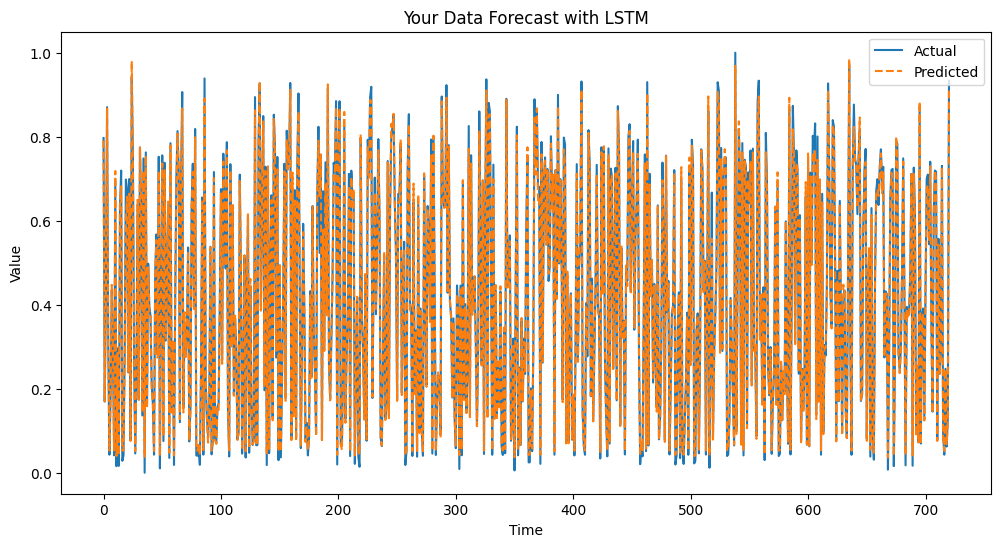

In [ ]:
# Function to prepare the data for LSTM
def prepare_lstm_data(df, feature, lookback=5):
    X, y = [], []
    for i in range(lookback, len(df)):
        X.append(df[feature][i-lookback:i])
        y.append(df[feature][i])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape to [samples, timesteps, features]
    return X, y

# Function to create and train an LSTM model
def train_lstm_model(X_train, y_train, input_shape, epochs=10, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    with open('lstm_model.pkl', 'wb') as f:
      pickle.dump(model, f)
    return model

# Function to evaluate the model and plot results
def evaluate_lstm_model(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{title} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


# Assuming your data is already loaded into normalized_df
X, y = prepare_lstm_data(normalized_df, 'Adj Close')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lstm_model = train_lstm_model(X_train, y_train, (X_train.shape[1], 1))
evaluate_lstm_model(lstm_model, X_test, y_test, "Your Data Forecast with LSTM")